In [1]:
!pip install torch pandas numpy matplotlib scikit-learn


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv("climate_change_dataset.csv")
df.head()

,Year,Country,Avg Temperature (°C),CO2 Emissions (Tons/Capita),Sea Level Rise (mm),Rainfall (mm),Population,Renewable Energy (%),Extreme Weather Events,Forest Area (%)
0,2006,UK,8.9,9.3,3.1,1441,530911230,20.4,14,59.8
1,2019,USA,31.0,4.8,4.2,2407,107364344,49.2,8,31.0
2,2014,France,33.9,2.8,2.2,1241,441101758,33.3,9,35.5
3,2010,Argentina,5.9,1.8,3.2,1892,1069669579,23.7,7,17.7
4,2007,Germany,26.9,5.6,2.4,1743,124079175,12.5,4,17.4


In [4]:
data = df.select_dtypes(include=[np.number])
data.head()

,Year,Avg Temperature (°C),CO2 Emissions (Tons/Capita),Sea Level Rise (mm),Rainfall (mm),Population,Renewable Energy (%),Extreme Weather Events,Forest Area (%)
0,2006,8.9,9.3,3.1,1441,530911230,20.4,14,59.8
1,2019,31.0,4.8,4.2,2407,107364344,49.2,8,31.0
2,2014,33.9,2.8,2.2,1241,441101758,33.3,9,35.5
3,2010,5.9,1.8,3.2,1892,1069669579,23.7,7,17.7
4,2007,26.9,5.6,2.4,1743,124079175,12.5,4,17.4


In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
tensor_data = torch.tensor(scaled_data, dtype=torch.float32)

In [6]:
input_dim = tensor_data.shape[1]
latent_dim = 20
batch_size = 64
epochs = 200
lr = 0.0002

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, z):
        return self.model(z)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [9]:
G = Generator()
D = Discriminator()

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr)
optimizer_D = optim.Adam(D.parameters(), lr=lr)

In [10]:
for epoch in range(epochs):
    idx = np.random.randint(0, tensor_data.size(0), batch_size)
    real_data = tensor_data[idx]

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    z = torch.randn(batch_size, latent_dim)
    fake_data = G(z)

    d_loss = criterion(D(real_data), real_labels) + criterion(D(fake_data.detach()), fake_labels)
    optimizer_D.zero_grad()
    d_loss.backward()
    optimizer_D.step()

    g_loss = criterion(D(fake_data), real_labels)
    optimizer_G.zero_grad()
    g_loss.backward()
    optimizer_G.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Epoch 0 | D Loss: 1.3691 | G Loss: 0.8078
Epoch 20 | D Loss: 1.3494 | G Loss: 0.7690
Epoch 40 | D Loss: 1.3295 | G Loss: 0.7418
Epoch 60 | D Loss: 1.3473 | G Loss: 0.7149
Epoch 80 | D Loss: 1.3446 | G Loss: 0.6917
Epoch 100 | D Loss: 1.3444 | G Loss: 0.6727
Epoch 120 | D Loss: 1.3459 | G Loss: 0.6601
Epoch 140 | D Loss: 1.3420 | G Loss: 0.6605
Epoch 160 | D Loss: 1.3591 | G Loss: 0.6410
Epoch 180 | D Loss: 1.3512 | G Loss: 0.6543


In [11]:
z = torch.randn(100, latent_dim)
synthetic_data = G(z).detach().numpy()

synthetic_data = scaler.inverse_transform(synthetic_data)

synthetic_df = pd.DataFrame(synthetic_data, columns=data.columns)
synthetic_df.head()

,Year,Avg Temperature (°C),CO2 Emissions (Tons/Capita),Sea Level Rise (mm),Rainfall (mm),Population,Renewable Energy (%),Extreme Weather Events,Forest Area (%)
0,2007.224609,2.967518,11.747598,3.720381,1756.975220,-204122512.0,33.693085,8.686630,38.971336
1,2006.501221,7.477811,2.238943,3.410458,1540.715332,-283828224.0,22.432253,9.208712,26.175737
2,2002.445801,26.234690,15.089638,6.471408,2899.246826,-736779136.0,54.858894,20.955442,48.941502
3,2009.350220,10.154380,2.435638,2.309059,1405.860718,-549704000.0,15.853917,7.707061,40.027580
4,2004.948364,4.791008,9.640838,5.343124,2748.651611,-676896768.0,33.670525,9.776277,56.294895


In [12]:
synthetic_df.to_csv("synthetic_climate_data.csv", index=False)


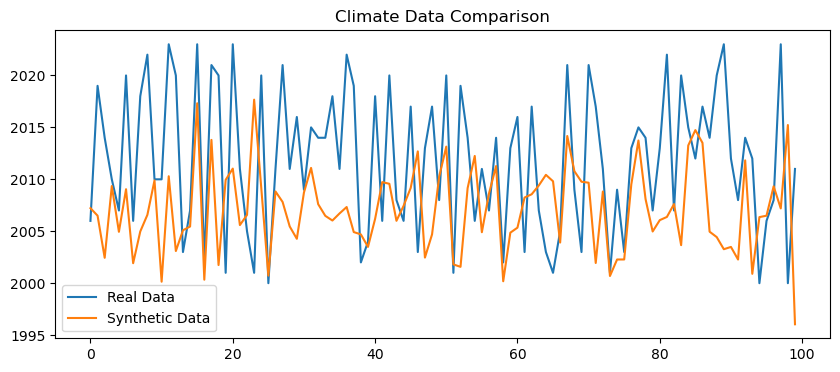

In [14]:
plt.figure(figsize=(10,4))
plt.plot(data.iloc[:100,0], label="Real Data")
plt.plot(synthetic_df.iloc[:100,0], label="Synthetic Data")
plt.legend()
plt.title("Climate Data Comparison")
plt.show()